In [1]:
from typing import List

import librosa
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from IPython.display import Audio
from sklearn.metrics import classification_report

##### Загружаем, слушаем и анализируем запись

In [2]:
waveform, sr = sf.read("Стрельба на улице.wav")
waveform = waveform / np.abs(waveform).max()

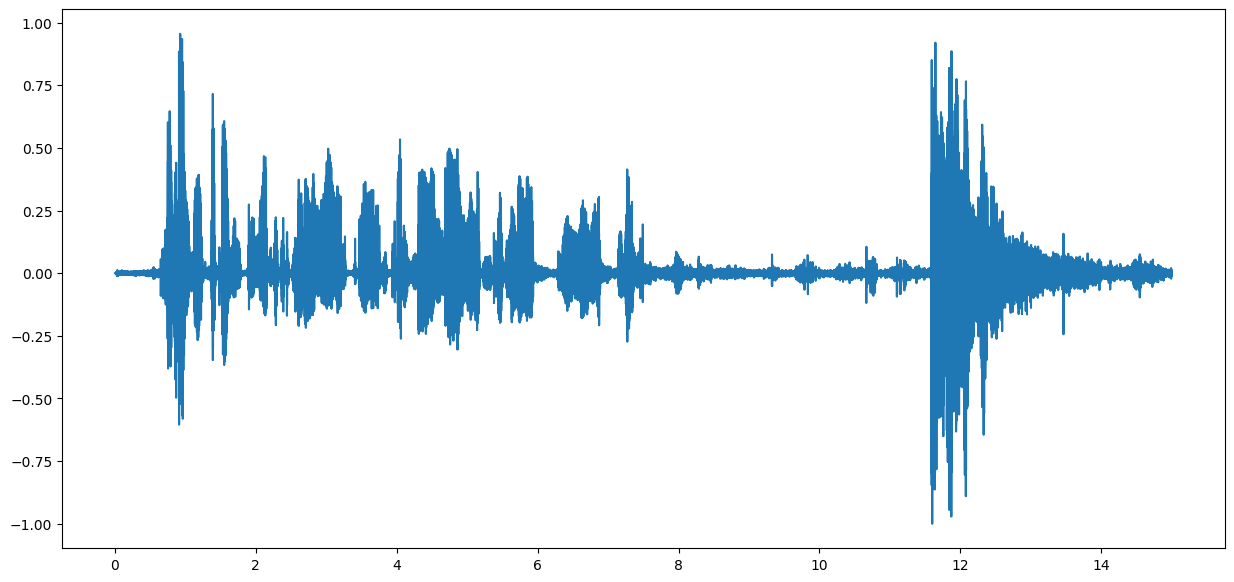

In [3]:
plt.figure(figsize=(15,7))
plt.plot(np.linspace(0, waveform.shape[0] // sr, num=waveform.shape[0]), waveform)
plt.show()

In [4]:
# Событие "выстрел" расположено примерно с 11.5 по 14 
Audio(data=waveform,  rate=sr)

In [5]:
def create_dataset(waveform: np.ndarray, sr: int, sample_durarion: float = 1.0, intersection: float = 0.5) -> List[np.ndarray]:
    win_length = int(sample_durarion * sr)
    hop_length = int(intersection * sr)
    waveform = np.pad(waveform, (hop_length, win_length - waveform.shape[0] % hop_length))

    samples = list[np.ndarray]()
    for idx in range((waveform.shape[0] - win_length) // hop_length):
        start = idx * hop_length
        samples.append(waveform[start : start + win_length])
    
    return samples

In [6]:
waveforms = create_dataset(waveform, sr)

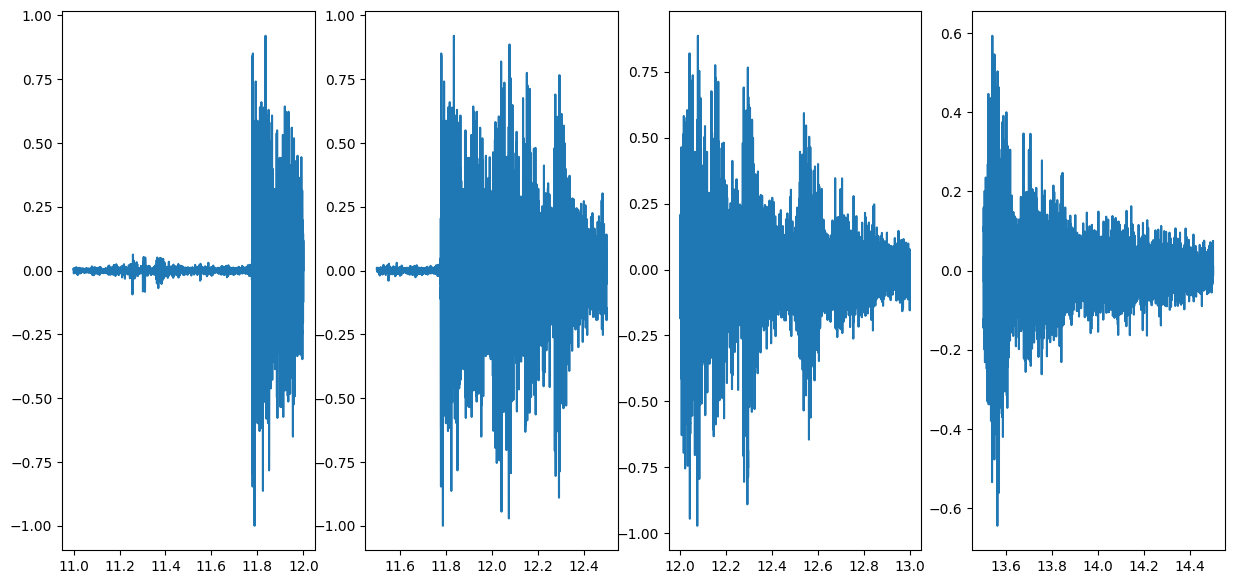

In [7]:
# Как мы выясняли, выстрел находится на интервале 11.5-14.0 секунд
# Т.к. перекрытие окна у нас 0.5 секунд, то событие будет находится в окнах: 24, 25, 26, 27
fig, axis = plt.subplots(1, 4)

fig.set_figwidth(15)
fig.set_figheight(7)

axis[0].plot(np.linspace(11.0, 12.0, sr), waveforms[24])
axis[1].plot(np.linspace(11.5, 12.5, sr), waveforms[25])
axis[2].plot(np.linspace(12.0, 13.0, sr), waveforms[26])
axis[3].plot(np.linspace(13.5, 14.5, sr), waveforms[27])
plt.show()

In [8]:
# Исходя из описанных выше данных, создаём метки класса
labels = [1 if 23 < idx < 28 else 0 for idx in range(len(waveforms))]

##### Подбираем гиперпараметры спектрограммы

In [9]:
n_fft = 2048
hop_length = 512
win_length = 2048

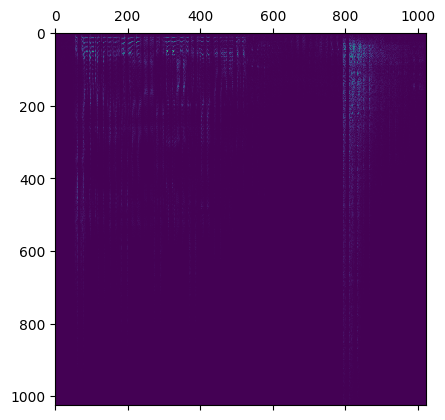

In [10]:
stft_s = list()
for i in range(len(waveforms)):
    stft = librosa.stft(
        waveforms[i], 
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window='hann',
    )
    stft_s.append(np.abs(stft))
plt.matshow(np.concatenate(stft_s, axis=1))
plt.show()

##### Выбираем частотный диапазон

In [11]:
begin_of_range = 100
end_range = 190

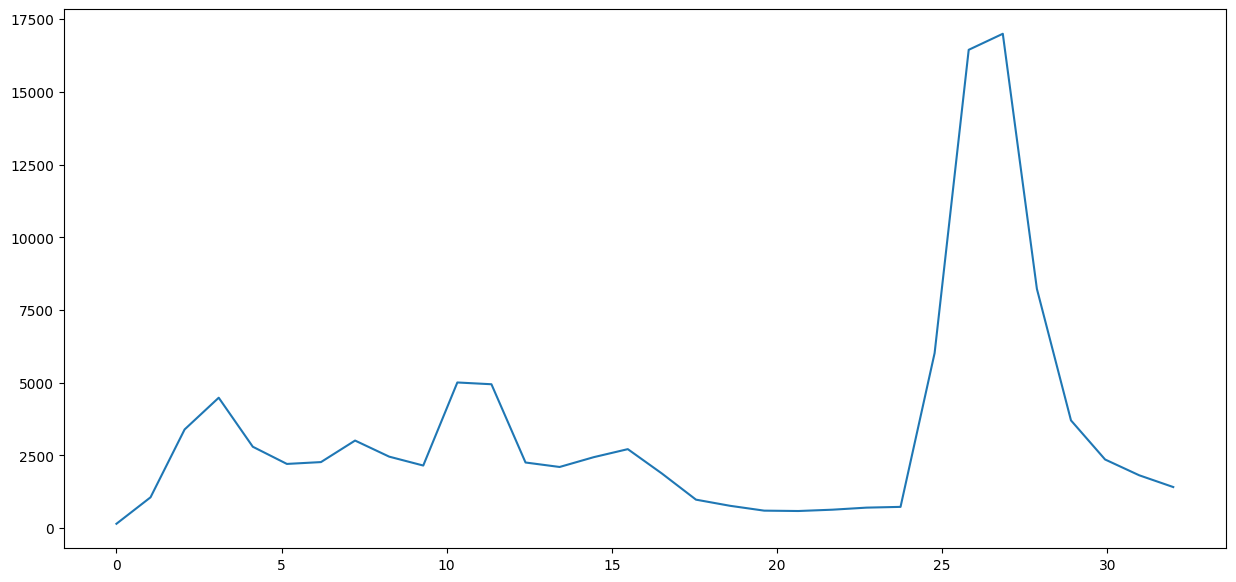

In [12]:
amplitude_specs = list()
for waveform_i in waveforms:
    stft = np.abs(librosa.stft(
        waveform_i, 
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window='hann',
    ))
    amplitude_specs.append(np.sum(stft[begin_of_range:end_range]))

plt.figure(figsize=(15,7))
plt.plot(np.linspace(0, len(amplitude_specs), num=len(amplitude_specs)), amplitude_specs)
plt.show()

##### Подбираем порог

In [13]:
print(amplitude_specs[24], amplitude_specs[25], amplitude_specs[26], amplitude_specs[27])

6019.667647229463 16446.05012613665 16997.53550063353 8226.677160353614


In [14]:
class EventDetector:
    def __init__(self, treshold: float = 6e3) -> None:
        self.treshold = treshold

    def __call__(self, waveform: np.ndarray) -> bool:
        stft = librosa.stft(
            waveform, 
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            window='hann',
        )
        stft = np.abs(stft)
        
        return np.sum(stft[begin_of_range:end_range]) > self.treshold

##### Оцениваем результаты

In [15]:
detector = EventDetector()
answers = list()
for waveform_i in waveforms:
    answers.append(detector(waveform_i))

In [16]:
print(classification_report(answers, labels))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        28
        True       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

